In [1]:
import os
base_path = os.path.dirname(os.path.abspath(""))
base_path = base_path + "/headers/"
print(base_path)
header_path = base_path + 'header_data_treatment.ipynb'
%run $header_path

C:\Users\raphael.wargon\Documents\GitHub\sorting_univ\script/headers/
initalizing spark nlp session w gpu


# Load data

In [2]:
works_au_af = (spark.read.format('parquet').load('file:\\' + main_path_openalex + 'works_au_af.parquet')
               .filter( func.col('publication_year').between(1950,2020) )
              )

In [3]:
df_inst = (spark.read.format('parquet').load('file:\\' + main_path_openalex + 'institutions.parquet')
           .withColumn('max_updated_date', func.max(func.col('updated_date')).over(Window.partitionBy('id')))
           .filter(func.col('updated_date') == func.col('max_updated_date'))
          )
df_inst.printSchema()


root
 |-- associated_institutions: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- country_code: string (nullable = true)
 |    |    |-- country_id: string (nullable = true)
 |    |    |-- display_name: string (nullable = true)
 |    |    |-- id: string (nullable = true)
 |    |    |-- lineage: array (nullable = true)
 |    |    |    |-- element: string (containsNull = true)
 |    |    |-- relationship: string (nullable = true)
 |    |    |-- ror: string (nullable = true)
 |    |    |-- type: string (nullable = true)
 |    |    |-- type_id: string (nullable = true)
 |-- cited_by_count: long (nullable = true)
 |-- country_code: string (nullable = true)
 |-- country_id: string (nullable = true)
 |-- counts_by_year: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- cited_by_count: long (nullable = true)
 |    |    |-- oa_works_count: long (nullable = true)
 |    |    |-- works_count: long (nullable = true)
 |    |

In [4]:
df_inst.select('display_name','topic_share').show(truncate = False)

+---------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# Build the raw dataset

In [7]:
au_inst_level_flow = (works_au_af
                      .filter(func.col('inst_id').isNotNull())
                    .withColumn('inst_id', func.when( (func.col('country')=="FR"), func.col('inst_id')).otherwise('abroad'))
                    .groupBy('author_id',func.col('publication_year').alias('year'))
                    .agg(func.collect_set('inst_id').alias('inst_id_set_y')
                        )

                    .withColumn('inst_id_set_last_y', func.lag(func.col('inst_id_set_y')).over(Window.partitionBy('author_id').orderBy('year')))
                    .withColumn('inst_id_receiver', func.explode(func.col('inst_id_set_y')))
                    .withColumn('inst_id_sender',  func.explode_outer(func.col('inst_id_set_last_y')))
                    .select('inst_id_receiver','inst_id_sender', 'author_id','year')
                   )

In [6]:
au_inst_level_flow.write.mode('overwrite').parquet('file:\\' + save_path + 'au_inst_level.parquet')

# Add inst-level info

In [5]:
au_inst_level_flow = spark.read.parquet('file:\\' + save_path + 'au_inst_level.parquet')

In [56]:

recoding= {   'I118618916'  :  "I899635006",
              "I36085230"   :  "I899635006",
              "I177483745"  :  "I899635006",
              "I4210103002" :  "I198244214",
              "I4210143836" :  "I198244214",
              "I184646667"  :  "I39804081",
              "I102197404"  :  "I277688954",
              'I7171862'    :  "I2279609970",
              "I59807433"   :  "I2279609970",
              "I2800379142" :  "I4210154111",
              "I3123023596" : "I56067802",
              "I4210095130" : "I208215962" 
          #  , "I4210140029": "I197518295"
}
recoding = spark.sparkContext.broadcast(recoding)
def recoding_univ(x):
    if x in list(recoding.keys()):
        return(recoding[x])
    else:
        return x
udf_recoding_univ = func.udf(recoding_univ, StringType())
list_fused = ["I21491767","I198244214","I4210142324",
                "I899635006","I899635006","I39804081",
                "I201841394","I4210154111","I204730241","I15057530",
                "I277688954","I68947357","I2279609970","I19894307"]
list_non_fr_non_uni_pub = ['I3131573726','I4210086079',
                             "I24240610","I16465266",'I35298706',
                             "I4210134562","I185839726","I4210143169",
                             "I4210127465","I10342815",
                             "I57206974","I193291145","I4210163862","I124357947",
                             "I97565354"]

In [38]:
inst = spark.read.parquet('file:\\' + save_path + 'inst_fr.parquet')

In [39]:
au_inst_level_flow = (au_inst_level_flow
                      .withColumn('inst_id_sender', func.when(func.col('inst_id_sender')=='I118618916',  "I899635006")
                                                        .when(func.col('inst_id_sender')=="I36085230",  "I899635006")
                                                        .when(func.col('inst_id_sender')=="I177483745",  "I899635006")
                                                        .when(func.col('inst_id_sender')=="I4210103002", "I198244214")
                                                        .when(func.col('inst_id_sender')=="I4210143836", "I198244214")
                                                        .when(func.col('inst_id_sender')=="I184646667",  "I39804081")
                                                        .when(func.col('inst_id_sender')=="I102197404",  "I277688954")
                                                        .when(func.col('inst_id_sender')=='I7171862',  "I2279609970")
                                                        .when(func.col('inst_id_sender')=="I59807433",  "I2279609970")
                                                        .when(func.col('inst_id_sender')=="I2800379142", "I4210154111") 
                                                        .when(func.col('inst_id_sender')=="I3123023596","I56067802")
                                                        .when(func.col('inst_id_sender')=="I4210095130","I208215962")
                                                   .otherwise(func.col('inst_id_sender')))
                      .withColumn('inst_id_receiver', func.when(func.col('inst_id_receiver')=='I118618916',  "I899635006")
                                                          .when(func.col('inst_id_receiver')=="I36085230",  "I899635006")
                                                          .when(func.col('inst_id_receiver')=="I177483745",  "I899635006")
                                                          .when(func.col('inst_id_receiver')=="I4210103002", "I198244214")
                                                          .when(func.col('inst_id_receiver')=="I4210143836", "I198244214")
                                                          .when(func.col('inst_id_receiver')=="I184646667",  "I39804081")
                                                          .when(func.col('inst_id_receiver')=="I102197404",  "I277688954")
                                                          .when(func.col('inst_id_receiver')=='I7171862',  "I2279609970")
                                                          .when(func.col('inst_id_receiver')=="I59807433",  "I2279609970")
                                                          .when(func.col('inst_id_receiver')=="I2800379142", "I4210154111") 
                                                          .when(func.col('inst_id_receiver')=="I3123023596","I56067802")
                                                          .when(func.col('inst_id_receiver')=="I4210095130","I208215962")
                                                     .otherwise(func.col('inst_id_receiver')))
                      .join(inst
                            .select(func.col('inst_id').alias('inst_id_receiver'), 
                                  *[func.col(col).alias(col +'_r') for col in ['name','city','parent','fused','uni_pub','cnrs','type','main_topic','idex','type_fr','secteur']],
                                   func.concat_ws(';', func.transform(func.col('topic_share'), lambda x: func.to_json(x))).alias('topic_share_r'))
                            , on = 'inst_id_receiver', how ='left')
                      .join(inst
                            .select(func.col('inst_id').alias('inst_id_sender'), 
                                    *[func.col(col).alias(col +'_s') for col in ['name','city','parent','fused','uni_pub','cnrs','type','main_topic']],
                                   func.concat_ws(';', func.transform(func.col('topic_share'), lambda x: func.to_json(x))).alias('topic_share_s'))
                            , on = 'inst_id_sender', how ='left')
                     )
au_inst_level_flow.printSchema()

root
 |-- inst_id_sender: string (nullable = true)
 |-- inst_id_receiver: string (nullable = true)
 |-- author_id: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- name_r: string (nullable = true)
 |-- city_r: string (nullable = true)
 |-- parent_r: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- parent_id: string (nullable = true)
 |    |    |-- parent_name: string (nullable = true)
 |    |    |-- parent_type: string (nullable = true)
 |-- fused_r: integer (nullable = true)
 |-- uni_pub_r: integer (nullable = true)
 |-- cnrs_r: integer (nullable = true)
 |-- type_r: string (nullable = true)
 |-- main_topic_r: string (nullable = true)
 |-- topic_share_r: string (nullable = true)
 |-- name_s: string (nullable = true)
 |-- city_s: string (nullable = true)
 |-- parent_s: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- parent_id: string (nullable = true)
 |    |    |-- parent_name: string (nulla

# institution-level raw flows

In [40]:
inst_level_flows = (au_inst_level_flow
                       .filter(func.col('year').between(1980,2020))
                    .withColumn('inst_id_sender', func.when(func.col('inst_id_sender').isNull(), 'entrant').otherwise(func.col('inst_id_sender')))
                    .withColumn('inst_set_sender', func.collect_set(func.col('inst_id_sender')).over(Window.partitionBy('author_id','year')))
                    .withColumn('all_parent_ids_r', func.array_except(func.transform(func.array_distinct(func.flatten(func.collect_set(func.col('parent_r.parent_id')).over(Window.partitionBy('year')))), lambda x: func.regexp_replace(x, 'https://openalex.org/', ''))
                                                                     , func.array(func.lit(None))))
                    .withColumn('test_drop_r', (func.array_contains(func.col('all_parent_ids_r'), func.col('inst_id_receiver'))).cast('int'))
                    .withColumn('all_parent_ids_s', func.array_except(func.transform(func.array_distinct(func.flatten(func.collect_set(func.col('parent_s.parent_id')).over(Window.partitionBy('year')))), lambda x: func.regexp_replace(x, 'https://openalex.org/', ''))
                                                                     , func.array(func.lit(None))))
                    .withColumn('test_drop_s', (func.array_contains(func.col('all_parent_ids_s'), func.col('inst_id_sender'))).cast('int'))
                    .filter(  ((func.col('test_drop_r')==0) | (func.col('test_drop_r').isNull()))  
                            & ( func.col('test_drop_s')==0) | (func.col('test_drop_s').isNull()) )
                    .withColumn('stayer', func.array_contains(func.col('inst_set_sender'), func.col('inst_id_receiver')).cast('int'))
                    .withColumn('weights', 1/func.count('inst_id_sender').over(Window.partitionBy('author_id','year')))
                      .groupBy('inst_id_receiver','inst_id_sender', 'year')
                      .agg(func.countDistinct('author_id').alias('total'),
                           func.sum('stayer').alias('stayers'),
                           func.sum(1-func.col('stayer')).alias('movers'),
                        
                           func.sum('weights').alias('total_w'),
                           func.sum(func.col('weights')*func.col('stayer')).alias('stayers_w'),
                           func.sum(func.col('weights')*(1-func.col('stayer'))).alias('movers_w'),
                           
                           *[func.first(func.col(col), ignorenulls = True).alias(col) for col in
                           [ colname + '_r' for colname in   ['name','city','parent','fused','uni_pub','cnrs','type','main_topic','topic_share','idex','type_fr','secteur']]
                             +[ colname + '_s' for colname in   ['name','city','parent','fused','uni_pub','cnrs','type','main_topic','topic_share','idex','type_fr','secteur']]
                            ]
                          )
                    .withColumn('type_r', func.when(func.col('inst_id_receiver')=="abroad", 'abroad').otherwise(func.col('type_r')))
                    .withColumn('type_s', func.when(func.col('inst_id_sender')=="abroad", 'abroad').otherwise(func.col('type_s')))
                    .fillna(0, subset = ['fused_r','fused_s','uni_pub_r','uni_pub_s','cnrs_r','cnrs_s'] )
                          .withColumn('size_r', func.max(func.col('stayers') * (func.col('inst_id_receiver')==func.col('inst_id_sender')).cast('int'))
                                      .over(Window.partitionBy('inst_id_receiver','year')))
                          .withColumn('size_s', func.max(func.col('stayers') * (func.col('inst_id_receiver')==func.col('inst_id_sender')).cast('int'))
                                      .over(Window.partitionBy('inst_id_sender','year')))
                   )


In [41]:
inst_level_flows.cache()
inst_level_flows.show()

Py4JJavaError: An error occurred while calling o1501.showString.
: org.apache.spark.SparkException: Job 45 cancelled because killed via the Web UI
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2856)
	at org.apache.spark.scheduler.DAGScheduler.handleJobCancellation(DAGScheduler.scala:2731)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleStageCancellation$1(DAGScheduler.scala:2720)
	at scala.runtime.java8.JFunction1$mcVI$sp.apply(JFunction1$mcVI$sp.java:23)
	at scala.collection.IndexedSeqOptimized.foreach(IndexedSeqOptimized.scala:36)
	at scala.collection.IndexedSeqOptimized.foreach$(IndexedSeqOptimized.scala:33)
	at scala.collection.mutable.ArrayOps$ofInt.foreach(ArrayOps.scala:246)
	at org.apache.spark.scheduler.DAGScheduler.handleStageCancellation(DAGScheduler.scala:2713)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3010)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2994)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2983)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)


In [ ]:
inst_level_flows.write.mode('overwrite').parquet('file:\\' + save_path + 'inst_level_flows.parquet')

In [4]:
inst_level_flows= spark.read.parquet('file:\\' + save_path + 'inst_level_flows.parquet')

In [6]:
inst_level_flows = (inst_level_flows
                    .join(inst.select(func.col('inst_id').alias('inst_id_sender'),
                                      func.col('main_topic').alias('main_topic_s')),
                          on = ['inst_id_sender'], how = 'left')
                   )

In [7]:
inst_level_flows.write.mode('overwrite').parquet('file:\\' + save_path + 'inst_level_flows_cor.parquet')

In [ ]:
spark.catalog.clearCache()
spark.stop()

In [40]:
inst_level_flows_moves = (inst_level_flows

                          .drop('stayers')
                         )
inst_level_flows_moves.show()

+----------------+--------------+----+-----+------+--------------------+--------------------+--------------------+--------------------+--------------------+-------+---------+------+--------------------+--------------------+-------+---------+------+------+------+
|inst_id_receiver|inst_id_sender|year|total|movers|             total_w|           stayers_w|            movers_w|              name_r|            parent_r|fused_r|uni_pub_r|cnrs_r|              name_s|            parent_s|fused_s|uni_pub_s|cnrs_s|size_r|size_s|
+----------------+--------------+----+-----+------+--------------------+--------------------+--------------------+--------------------+--------------------+-------+---------+------+--------------------+--------------------+-------+---------+------+------+------+
|      I100532134|    I100532134|2016| 3514|     0|   412.1588552860467|   412.1588552860467|                 0.0|Université Claude...|[{"parent_id":"I2...|      0|        1|     0|Université Claude...|[{"parent

In [44]:
inst_level_flows_moves.filter(func.col('inst_id_receiver')=="I57995698").groupBy('year').agg(func.sum('movers').alias('movers'),
                                                                                             func.sum('movers_w').alias('movers_w')).sort('year').collect()

[Row(year=1984, movers=2, movers_w=0.3333333333333333),
 Row(year=1988, movers=3, movers_w=0.75),
 Row(year=1989, movers=1, movers_w=0.3333333333333333),
 Row(year=1990, movers=1, movers_w=0.5),
 Row(year=1991, movers=1, movers_w=0.3333333333333333),
 Row(year=1992, movers=3, movers_w=0.8333333333333333),
 Row(year=1993, movers=0, movers_w=0.0),
 Row(year=1994, movers=1, movers_w=0.25),
 Row(year=1995, movers=1, movers_w=1.0),
 Row(year=1996, movers=9, movers_w=3.7500000000000004),
 Row(year=1997, movers=6, movers_w=2.6666666666666665),
 Row(year=1998, movers=3, movers_w=0.75),
 Row(year=1999, movers=9, movers_w=2.25),
 Row(year=2000, movers=10, movers_w=2.0833333333333335),
 Row(year=2001, movers=16, movers_w=4.316666666666666),
 Row(year=2002, movers=11, movers_w=1.9833333333333332),
 Row(year=2003, movers=59, movers_w=4.710673234811164),
 Row(year=2004, movers=24, movers_w=4.0249999999999995),
 Row(year=2005, movers=44, movers_w=7.15238095238095),
 Row(year=2006, movers=36, movers_w

In [54]:
(inst_level_flows_moves
 .filter(func.col('inst_id_receiver')=="I57995698")
 .filter(func.col('year')==2013)
 .withColumn('name_s', func.when(func.col('name_s').isNull(), func.col('inst_id_sender')).otherwise(func.col('name_s')))
 .select('name_r','name_s','movers','movers_w').filter('movers>0')).show(100,truncate = False)

+-------------------------+--------------------------------------------------------------------------+------+--------------------+
|name_r                   |name_s                                                                    |movers|movers_w            |
+-------------------------+--------------------------------------------------------------------------+------+--------------------+
|Paris School of Economics|I4210103002                                                               |1     |0.04                |
|Paris School of Economics|Alimentation et Sciences Sociales                                         |1     |0.5                 |
|Paris School of Economics|Aix-Marseille Université                                                  |1     |0.0625              |
|Paris School of Economics|Institut national d'études démographiques                                 |1     |0.5                 |
|Paris School of Economics|Laboratoire Psychologie de la Perception                

In [55]:
to_plot = (inst_level_flows_moves
           .filter( (func.col('inst_id_receiver') != func.col('inst_id_sender')))
           .filter(func.col('inst_id_sender')!="abroad")
           .groupBy('year','uni_pub_r')
           .agg(func.sum('movers').alias('total_flow'),
                func.mean('movers').alias('avg_flow'),
                func.sum('total').alias('total'),
                func.sum('movers_w').alias('total_flow_w'),
                func.mean('movers_w').alias('avg_flow_w'),
                func.sum('total_w').alias('total_w')
               )
          ).toPandas()

C:\Users\raphael.wargon\AppData\Local\Temp\ipykernel_11820\1568416090.py:65: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([round(x, 4) for x in current_values])


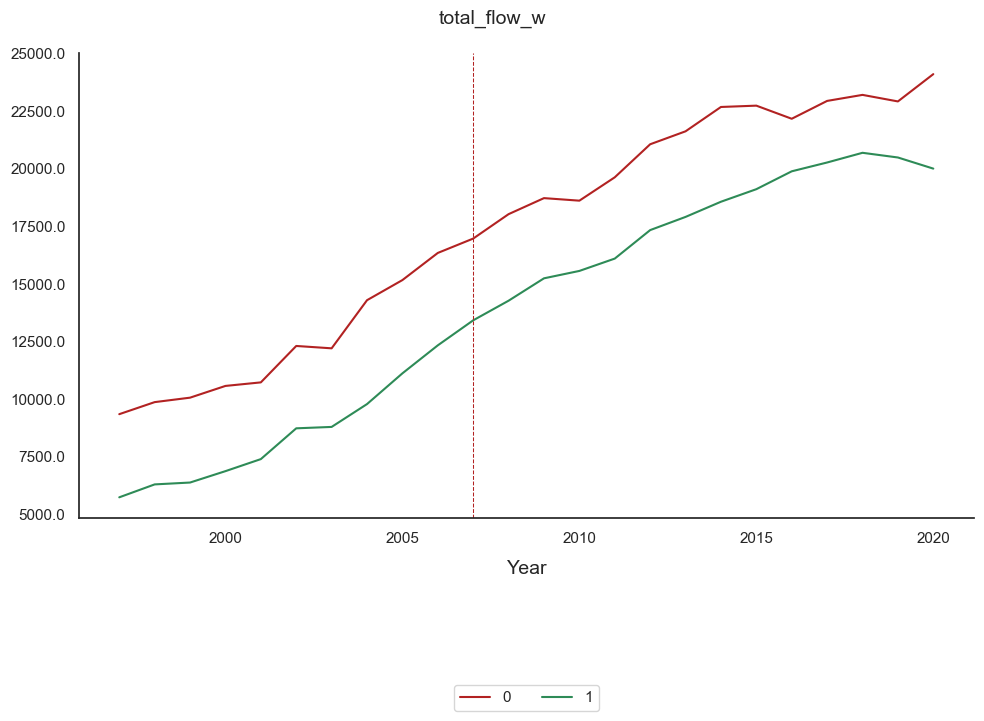

In [56]:
year_of_change = [2007]
graph_3(to_plot[to_plot['year']>=1997], 'year','total_flow_w', 'uni_pub_r', [0,1])

C:\Users\raphael.wargon\AppData\Local\Temp\ipykernel_11820\1568416090.py:65: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([round(x, 4) for x in current_values])


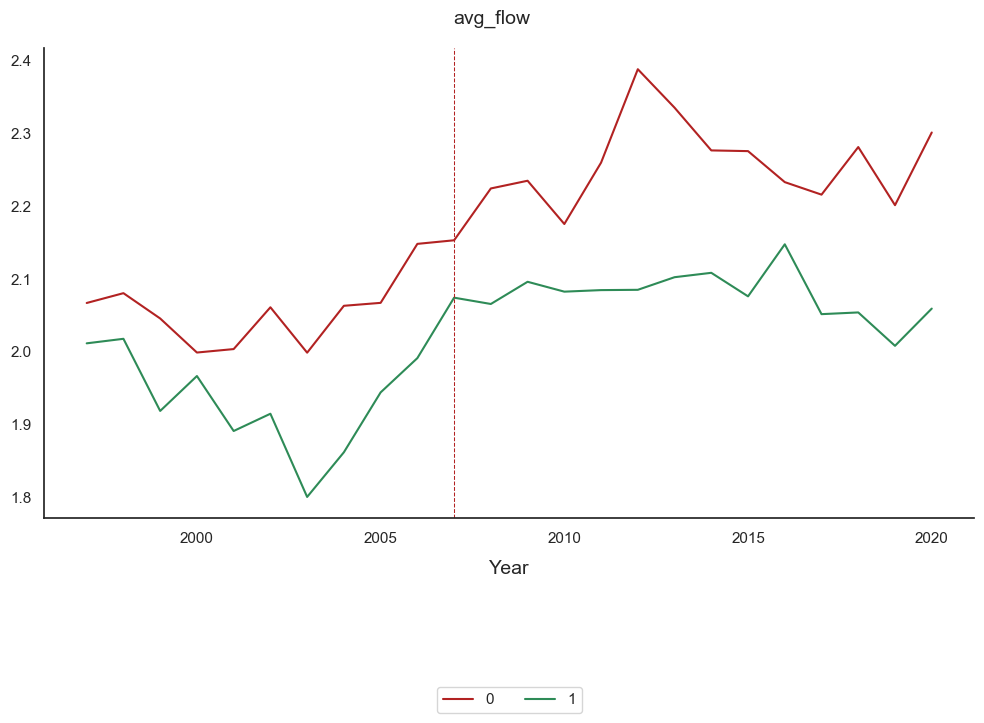

In [57]:
graph_3(to_plot[to_plot['year']>=1997], 'year','avg_flow', 'uni_pub_r', [0,1])

C:\Users\raphael.wargon\AppData\Local\Temp\ipykernel_11820\1568416090.py:65: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([round(x, 4) for x in current_values])


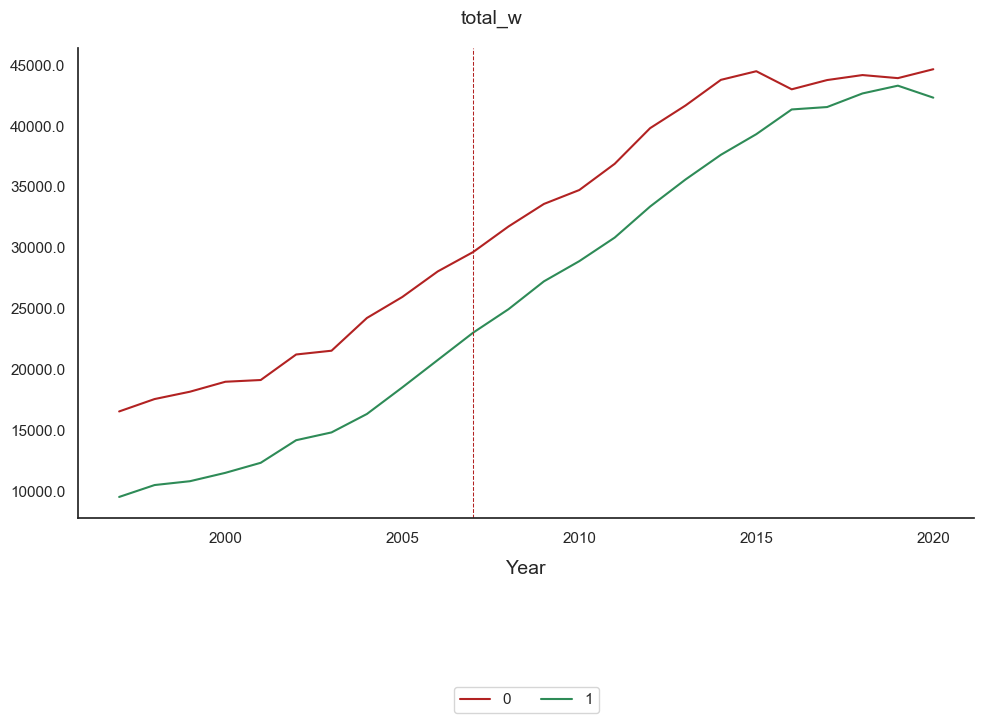

In [58]:
graph_3(to_plot[to_plot['year']>=1997], 'year','total_w', 'uni_pub_r', [0,1])

C:\Users\raphael.wargon\AppData\Local\Temp\ipykernel_11820\1568416090.py:65: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([round(x, 4) for x in current_values])
C:\Users\raphael.wargon\AppData\Local\Temp\ipykernel_11820\1568416090.py:65: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([round(x, 4) for x in current_values])


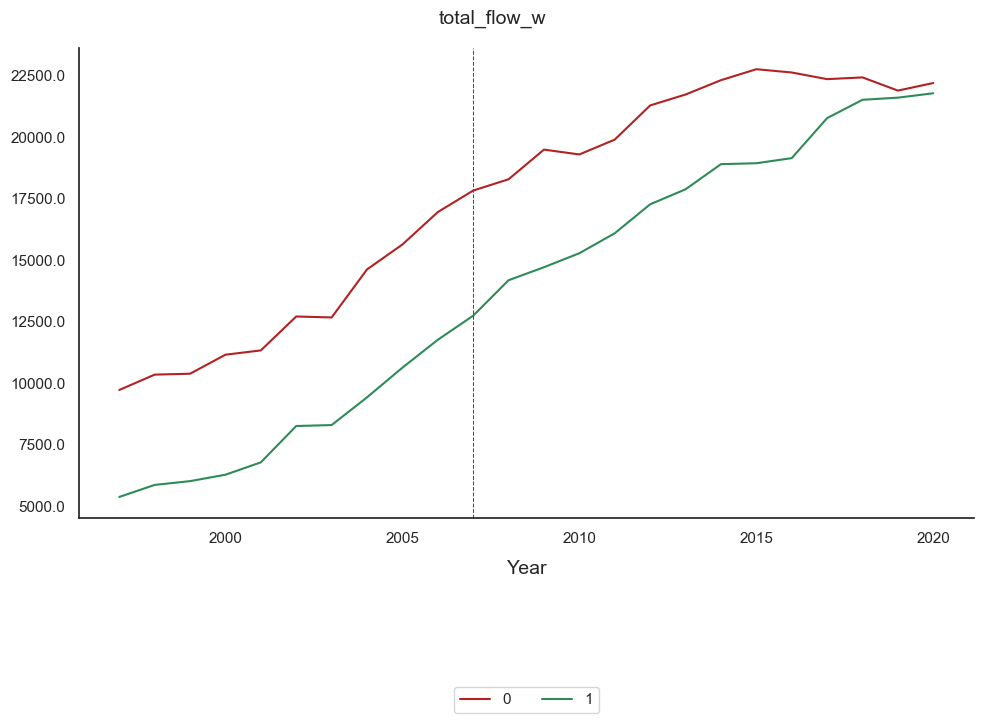

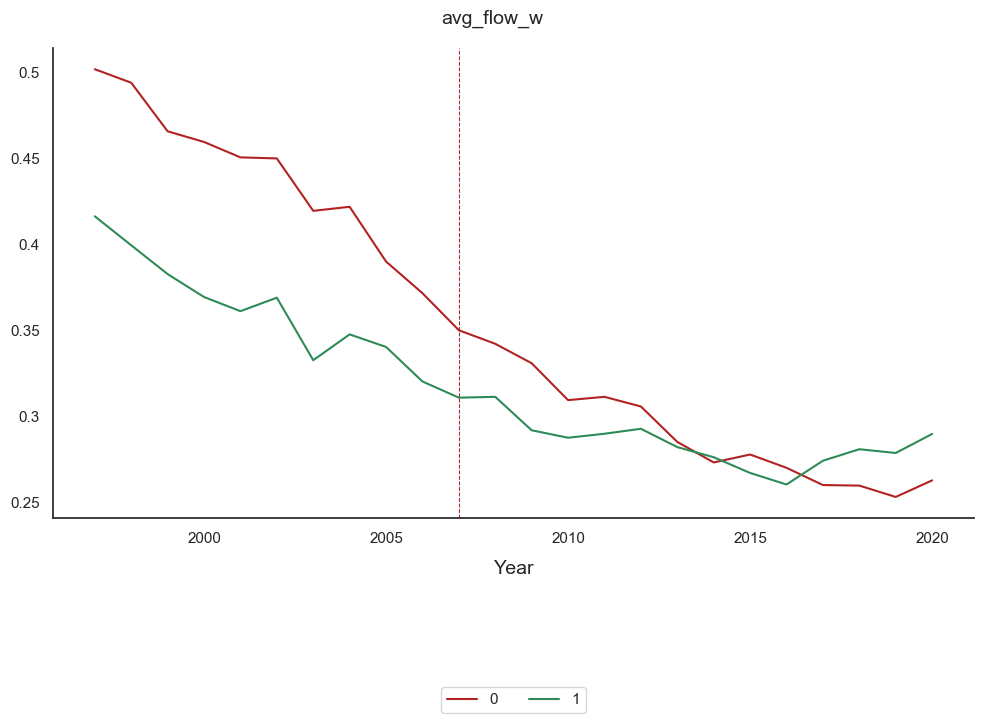

In [61]:
to_plot = (inst_level_flows_moves
           .filter( (func.col('inst_id_receiver') != func.col('inst_id_sender')))
           .filter(func.col('inst_id_receiver')!="abroad")
           .filter(func.col('inst_typr')!="company")
           .groupBy('year','uni_pub_s')
           .agg(func.sum('movers').alias('total_flow'),
                func.mean('movers').alias('avg_flow'),
                func.sum('total').alias('total'),
                func.sum('movers_w').alias('total_flow_w'),
                func.mean('movers_w').alias('avg_flow_w'),
                func.sum('total_w').alias('total_w')
               )
          ).toPandas()
graph_3(to_plot[to_plot['year']>=1997], 'year','total_flow_w', 'uni_pub_s', [0,1])
graph_3(to_plot[to_plot['year']>=1997], 'year','avg_flow_w', 'uni_pub_s', [0,1])